In [67]:
import fastText #version 0.8.22
import pandas as pd
import os
from fastText import train_supervised
import numpy as np

In [2]:
# To show the output of all lines in a cell rather that just the last line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

`The architecture of fasttext supervised learning is like word2vec CBOW where the target word is replaced with the label.`

In [3]:
def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))

In [4]:
DATA_DIR = "~/Downloads/ft_amazon/"

Source: https://www.kaggle.com/bittlingmayer/amazonreviews#train.ft.txt.bz2

In [16]:
train_data = pd.read_table(DATA_DIR+"train.ft.txt", header=None, names=['sentence'])
train_data.shape

(3600000, 1)

In [6]:
train_data.head(10)

,sentence
0,__label__2 Stuning even for the non-gamer: Thi...
1,__label__2 The best soundtrack ever to anythin...
2,__label__2 Amazing!: This soundtrack is my fav...
3,__label__2 Excellent Soundtrack: I truly like ...
4,"__label__2 Remember, Pull Your Jaw Off The Flo..."
5,__label__2 an absolute masterpiece: I am quite...
6,__label__1 Buyer beware: This is a self-publis...
7,__label__2 Glorious story: I loved Whisper of ...
8,__label__2 A FIVE STAR BOOK: I just finished r...
9,__label__2 Whispers of the Wicked Saints: This...


`__label__1` is negative sentiment and `__label__2` is positive sentiment

In [44]:
test_data = pd.read_table(DATA_DIR+"test.ft.txt", header=None, names=['sentence'])
test_data.shape

(400000, 1)

train_data is too large for our case. So I'm going to use test_data only.

In [45]:
import re

def normalize(row):
    lower = row['sentence'].lower()
    #correct all multiple white spaces to a single white space
    no_mult_ws = re.sub('[\s]+', ' ', lower)
    text = no_mult_ws.strip()
    return text

In [46]:
test_data['normalized_sentence'] = test_data.apply(normalize, axis=1)

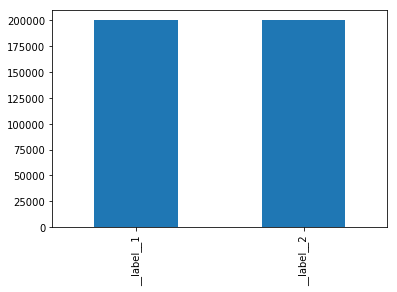

In [47]:
test_data['label'] = test_data['normalized_sentence'].apply(lambda row: row[0:10])
test_data['just_sentence'] = test_data['normalized_sentence'].apply(lambda row: row[10:])
test_data.drop(['sentence', 'normalized_sentence'], axis=1, inplace=True)
%matplotlib inline
test_data['label'].value_counts().plot(kind='bar')

In [48]:
test_data.head(3)

,label,just_sentence
0,__label__2,great cd: my lovely pat has one of the great ...
1,__label__2,one of the best game music soundtracks - for ...
2,__label__1,batteries died within a year ...: i bought th...


In [49]:
from sklearn.model_selection import train_test_split

dummy_train_data, dummy_test_data = train_test_split(test_data, test_size=0.35, random_state=4)

In [50]:
dummy_train_data.shape
dummy_test_data.shape

(260000, 2)

(140000, 2)

In [51]:
dummy_train_data.to_csv(path_or_buf=os.path.join(DATA_DIR, 'dummy_ft_amazon.train'), header=False, index=False, sep='\t')
dummy_test_data.to_csv(path_or_buf=os.path.join(DATA_DIR, 'dummy_ft_amazon.test'), header=False, index=False, sep='\t')

In [52]:
train_data_path = '/Users/hadi.minooei/Downloads/ft_amazon/dummy_ft_amazon.train'#os.path.join(DATA_DIR, 'ft_amazon.train')
test_data_path = '/Users/hadi.minooei/Downloads/ft_amazon/dummy_ft_amazon.test' #os.path.join(DATA_DIR, 'ft_amazon.test')

%time amazon_sentiment_model = train_supervised(input=train_data_path, lr=0.9, dim=200, ws=5, epoch=2, minn=3, maxn=4, neg=5, wordNgrams=1, loss="ns", bucket=200000)

print("On train")
print_results(*amazon_sentiment_model.test(train_data_path))
print("On test")
print_results(*amazon_sentiment_model.test(test_data_path))
amazon_sentiment_model.save_model("amazon_sentiment_model.bin")

CPU times: user 8min 11s, sys: 2.84 s, total: 8min 13s
Wall time: 1min 19s
On train
N	260000
P@1	0.904
R@1	0.904
On test
N	140000
P@1	0.897
R@1	0.897


In [63]:
%time amazon_sentiment_model = train_supervised(input=train_data_path, lr=0.9, dim=200, ws=5, epoch=5, minn=3, maxn=4, neg=5, wordNgrams=1, loss="ova", bucket=200000)

print("On train")
print_results(*amazon_sentiment_model.test(train_data_path))
print("On test")
print_results(*amazon_sentiment_model.test(test_data_path))

CPU times: user 22min 33s, sys: 3.9 s, total: 22min 37s
Wall time: 3min 22s
On train
N	260000
P@1	0.916
R@1	0.916
On test
N	140000
P@1	0.901
R@1	0.901


In [66]:
amazon_sentiment_model.predict("you are not a cool guy but still i like you", k=2)
amazon_sentiment_model.predict("yeah..", k=2)
amazon_sentiment_model.predict("k", k=2)
amazon_sentiment_model.predict("k. Don't talk to me. wtf? love is coming", k=2)
amazon_sentiment_model.predict("I'm sad. But sometimes very happy to see people smile", k=2)

amazon_sentiment_model.predict("the best soundtrack ever to anything.: i'm reading a lot of reviews saying that this is the best 'game soundtrack' and i figured that i'd write a review to disagree a bit. this in my opinino is yasunori mitsuda's ultimate masterpiece. the music is timeless and i'm been listening to it for years now and its beauty simply refuses to fade.the price tag on this is pretty staggering i must say, but if you are going to buy any cd for this much money, this is the only one that i feel would be worth every penny.", k=2)

amazon_sentiment_model.predict("I'm sad.", k=2)
amazon_sentiment_model.predict("how are you doing?", k=2)
amazon_sentiment_model.predict("I don't like you", k=2)
amazon_sentiment_model.predict("I dont like you", k=2)
amazon_sentiment_model.predict("I hate you", k=2)
amazon_sentiment_model.predict("I like you", k=2)
amazon_sentiment_model.predict("I like u", k=2)
amazon_sentiment_model.predict("What??", k=2)
amazon_sentiment_model.predict("COME HERE", k=2)
amazon_sentiment_model.predict("come here", k=2)

(('__label__1', '__label__2'), array([ 0.60767317,  0.39234683]))

(('__label__2', '__label__1'), array([ 0.77730989,  0.22271016]))

(('__label__1', '__label__2'), array([ 0.81758451,  0.1871427 ]))

(('__label__1', '__label__2'), array([ 0.64423513,  0.3629792 ]))

(('__label__2', '__label__1'), array([ 0.98795623,  0.01169726]))

(('__label__2', '__label__1'), array([ 0.89030427,  0.10971579]))

(('__label__1', '__label__2'), array([  1.00001001e+00,   1.00000034e-05]))

(('__label__1', '__label__2'), array([ 0.96886617,  0.03115383]))

(('__label__1', '__label__2'), array([ 0.94967937,  0.05185546]))

(('__label__1', '__label__2'), array([ 0.99720907,  0.00281093]))

(('__label__1', '__label__2'), array([  1.00001001e+00,   1.00000034e-05]))

(('__label__2', '__label__1'), array([  1.00001001e+00,   1.00000034e-05]))

(('__label__2', '__label__1'), array([  1.00001001e+00,   1.00000034e-05]))

(('__label__1', '__label__2'), array([  1.00001001e+00,   1.00000034e-05]))

(('__label__2', '__label__1'), array([ 0.72488028,  0.27513972]))

(('__label__2', '__label__1'), array([ 0.96979541,  0.03115383]))

In [54]:
amazon_sentiment_model.predict("you are not a cool guy but still i like you", k=2)
amazon_sentiment_model.predict("yeah..", k=2)
amazon_sentiment_model.predict("k", k=2)
amazon_sentiment_model.predict("k. Don't talk to me. wtf? love is coming", k=2)
amazon_sentiment_model.predict("I'm sad. But sometimes very happy to see people smile", k=2)

(('__label__1', '__label__2'), array([ 0.04085571,  0.00447838]))

(('__label__2', '__label__1'), array([  1.00000034e-05,   1.00000034e-05]))

(('__label__2', '__label__1'), array([  1.00000034e-05,   1.00000034e-05]))

(('__label__1', '__label__2'), array([ 0.06755669,  0.01206378]))

(('__label__2', '__label__1'), array([  7.49097228e-01,   1.00000034e-05]))

In [55]:
amazon_sentiment_model.quantize(input=train_data_path, qnorm=True, retrain=True, cutoff=200000)
amazon_sentiment_model.save_model("amazon_sentiment_model.ftz")

In [56]:
amazon_sentiment_model.predict("you are not a cool guy but still i like you", k=2)
amazon_sentiment_model.predict("yeah..", k=2)
amazon_sentiment_model.predict("k", k=2)
amazon_sentiment_model.predict("k. Don't talk to me. wtf? love is coming", k=2)
amazon_sentiment_model.predict("I'm sad. But sometimes very happy to see people smile", k=2)

(('__label__1', '__label__2'), array([ 0.02676929,  0.00858749]))

(('__label__2', '__label__1'), array([  1.00000034e-05,   1.00000034e-05]))

(('__label__2', '__label__1'), array([  1.00000034e-05,   1.00000034e-05]))

(('__label__1', '__label__2'), array([ 0.12253322,  0.00523013]))

(('__label__2', '__label__1'), array([  8.59673738e-01,   1.00000034e-05]))

In [57]:
amazon_sentiment_model.predict("the best soundtrack ever to anything.: i'm reading a lot of reviews saying that this is the best 'game soundtrack' and i figured that i'd write a review to disagree a bit. this in my opinino is yasunori mitsuda's ultimate masterpiece. the music is timeless and i'm been listening to it for years now and its beauty simply refuses to fade.the price tag on this is pretty staggering i must say, but if you are going to buy any cd for this much money, this is the only one that i feel would be worth every penny.", k=2)

(('__label__2', '__label__1'), array([ 0.70579505,  0.02162533]))

In [58]:
amazon_sentiment_model.predict("I'm sad.", k=2)
amazon_sentiment_model.predict("how are you doing?", k=2)
amazon_sentiment_model.predict("I don't like you", k=2)
amazon_sentiment_model.predict("I dont like you", k=2)
amazon_sentiment_model.predict("I hate you", k=2)
amazon_sentiment_model.predict("I like you", k=2)
amazon_sentiment_model.predict("I like u", k=2)
amazon_sentiment_model.predict("What??", k=2)
amazon_sentiment_model.predict("COME HERE", k=2)
amazon_sentiment_model.predict("come here", k=2)

(('__label__1', '__label__2'), array([  2.75952797e-02,   1.00000034e-05]))

(('__label__1', '__label__2'), array([  1.00235688e-02,   1.00000034e-05]))

(('__label__1', '__label__2'), array([  2.06074328e-03,   1.00000034e-05]))

(('__label__1', '__label__2'), array([  5.34133315e-02,   1.00000034e-05]))

(('__label__1', '__label__2'), array([  1.00001001e+00,   1.00000034e-05]))

(('__label__2', '__label__1'), array([  6.07673168e-01,   1.00000034e-05]))

(('__label__2', '__label__1'), array([  3.73368822e-02,   1.00000034e-05]))

(('__label__1', '__label__2'), array([  1.00001001e+00,   1.00000034e-05]))

(('__label__2', '__label__1'), array([  1.00000034e-05,   1.00000034e-05]))

(('__label__2', '__label__1'), array([  8.39589280e-04,   1.00000034e-05]))

In [62]:
amazon_sentiment_model.predict("yes my dear", k=2)
amazon_sentiment_model.predict("yes yes yes yes ", k=2)
amazon_sentiment_model.predict("yeah", k=2)
amazon_sentiment_model.predict("yea..", k=2)

(('__label__2', '__label__1'), array([  5.29304962e-04,   1.00000034e-05]))

(('__label__2', '__label__1'), array([  1.00000034e-05,   1.00000034e-05]))

(('__label__2', '__label__1'), array([  9.26977769e-02,   1.00000034e-05]))

(('__label__2', '__label__1'), array([  1.00000034e-05,   1.00000034e-05]))

In [60]:
amazon_sentiment_model.get_word_vector("yes")

array([ 0.00702428, -0.03036053, -0.04076362, -0.0511793 ,  0.00246873,
       -0.02896596,  0.00036038, -0.13051659, -0.02642843,  0.00214846,
       -0.04816673,  0.00378879, -0.03372801, -0.03234226,  0.04137009,
        0.0154534 ,  0.03766073, -0.03382223, -0.01120388,  0.05668296,
       -0.07652482,  0.07222897,  0.01722587, -0.09898116, -0.02289472,
        0.03606266,  0.06226617,  0.06625992, -0.02564876,  0.05592393,
       -0.0159695 , -0.04539906, -0.02620546, -0.06140228, -0.02237021,
       -0.01634643,  0.08660805, -0.02522014, -0.02246197,  0.06793543,
       -0.03315295,  0.00539113, -0.00745034, -0.0204278 ,  0.01407906,
        0.04252351,  0.06141054,  0.05864266,  0.03282303,  0.01800473,
       -0.01683378, -0.00352212,  0.03540189,  0.03838973, -0.03967331,
       -0.03798168, -0.02102506, -0.06027415,  0.00806519,  0.00575939,
        0.02393338, -0.02595625, -0.06061789,  0.02943574,  0.02196301,
       -0.0295465 , -0.0407875 , -0.01173892, -0.00636694,  0.04

Trying transfer learning

In [13]:
%time amazon_sentiment_model_transfer = train_supervised(input=train_data_path, lr=0.1, dim=300, epoch=2, loss='ns', bucket=200000, label="__label__", pretrainedVectors="/Users/hadi.minooei/Downloads/wiki-news-300d-1M.vec")
print("On train")
print_results(*amazon_sentiment_model_transfer.test(train_data_path))
print("On test")
print_results(*amazon_sentiment_model_transfer.test(test_data_path))

CPU times: user 5min 38s, sys: 8.93 s, total: 5min 47s
Wall time: 4min 24s
On train
N	260000
P@1	0.910
R@1	0.910
On test
N	140000
P@1	0.894
R@1	0.894


In [14]:
%time amazon_sentiment_model_transfer = train_supervised(input=train_data_path, lr=0.9, dim=300, epoch=2, loss='ns', bucket=200000, label="__label__", pretrainedVectors="/Users/hadi.minooei/Downloads/wiki-news-300d-1M.vec")
print("On train")
print_results(*amazon_sentiment_model_transfer.test(train_data_path))
print("On test")
print_results(*amazon_sentiment_model_transfer.test(test_data_path))

CPU times: user 5min 34s, sys: 8.32 s, total: 5min 42s
Wall time: 4min 20s
On train
N	260000
P@1	0.909
R@1	0.909
On test
N	140000
P@1	0.893
R@1	0.893


In [25]:
%time amazon_sentiment_model_transfer = train_supervised(input=train_data_path, lr=0.9, dim=300, epoch=5, loss='ns', bucket=200000, label="__label__", pretrainedVectors="/Users/hadi.minooei/Downloads/wiki-news-300d-1M.vec")
print("On train")
print_results(*amazon_sentiment_model_transfer.test(train_data_path))
print("On test")
print_results(*amazon_sentiment_model_transfer.test(test_data_path))

CPU times: user 8min 7s, sys: 7.35 s, total: 8min 14s
Wall time: 4min 41s
On train
N	260000
P@1	0.925
R@1	0.925
On test
N	140000
P@1	0.896
R@1	0.896


Looks like more epochs is now causing overfitting..

In [23]:
%time amazon_sentiment_model_transfer = train_supervised(input=train_data_path, lr=0.9, dim=300, epoch=2, minn=3, maxn=4, loss='ns', bucket=200000, label="__label__", pretrainedVectors="/Users/hadi.minooei/Downloads/wiki-news-300d-1M.vec")
print("On train")
print_results(*amazon_sentiment_model_transfer.test(train_data_path))
print("On test")
print_results(*amazon_sentiment_model_transfer.test(test_data_path))

CPU times: user 17min 9s, sys: 15.2 s, total: 17min 25s
Wall time: 6min 16s
On train
N	260000
P@1	0.905
R@1	0.905
On test
N	140000
P@1	0.897
R@1	0.897


### Testing with removing punctuations

In [37]:
import re
import string

def normalize(row, col_name):
    lower = row[col_name].lower()
    #correct all multiple white spaces to a single white space
    no_mult_ws = re.sub('[\s]+', ' ', lower)
    striped = no_mult_ws.strip()
    #remove punctuations
    no_punc = striped.translate(str.maketrans('', '', string.punctuation))
    return no_punc

In [38]:
test_data = pd.read_table(DATA_DIR+"test.ft.txt", header=None, names=['label_sentence'])

test_data['label'] = test_data['label_sentence'].apply(lambda row: row[0:10])
test_data['sentence'] = test_data['label_sentence'].apply(lambda row: row[10:])
test_data['normalized_sentence'] = test_data.apply(lambda row: normalize(row, 'sentence'), axis=1)

test_data.drop(['label_sentence', 'sentence'], axis=1, inplace=True)

In [39]:
test_data.head(3)

,label,normalized_sentence
0,__label__2,great cd my lovely pat has one of the great vo...
1,__label__2,one of the best game music soundtracks for a ...
2,__label__1,batteries died within a year i bought this ch...


In [40]:
from sklearn.model_selection import train_test_split

dummy_train_data, dummy_test_data = train_test_split(test_data, test_size=0.35, random_state=4)

In [41]:
dummy_train_data.to_csv(path_or_buf=os.path.join(DATA_DIR, 'dummy_ft_amazon_punc.train'), header=False, index=False, sep='\t')
dummy_test_data.to_csv(path_or_buf=os.path.join(DATA_DIR, 'dummy_ft_amazon_punc.test'), header=False, index=False, sep='\t')

In [42]:
train_data_path = '/Users/hadi.minooei/Downloads/ft_amazon/dummy_ft_amazon_punc.train'
test_data_path = '/Users/hadi.minooei/Downloads/ft_amazon/dummy_ft_amazon_punc.test'

%time amazon_sentiment_model = train_supervised(input=train_data_path, lr=0.9, dim=200, ws=5, epoch=2, minn=3, maxn=4, neg=5, wordNgrams=1, loss="ns", bucket=200000)

print("On train")
print_results(*amazon_sentiment_model.test(train_data_path))
print("On test")
print_results(*amazon_sentiment_model.test(test_data_path))

CPU times: user 8min 4s, sys: 4.11 s, total: 8min 8s
Wall time: 1min 18s
On train
N	260000
P@1	0.900
R@1	0.900
On test
N	140000
P@1	0.894
R@1	0.894


In [43]:
%time amazon_sentiment_model = train_supervised(input=train_data_path, lr=0.9, dim=200, ws=5, epoch=5, minn=3, maxn=4, neg=5, wordNgrams=1, loss="ns", bucket=200000)

print("On train")
print_results(*amazon_sentiment_model.test(train_data_path))
print("On test")
print_results(*amazon_sentiment_model.test(test_data_path))

CPU times: user 20min 50s, sys: 7.87 s, total: 20min 58s
Wall time: 3min 22s
On train
N	260000
P@1	0.907
R@1	0.907
On test
N	140000
P@1	0.898
R@1	0.898


Needs further grid_search ...